In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,accuracy_score
import pickle

# Reading the data

In [2]:
dataset = pd.read_csv('heart-disease.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Exploratory data analysis

In [3]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## The male to female ration on the dataset

In [5]:
dataset['sex'] = np.where(dataset['sex']==1,'Male','Female')

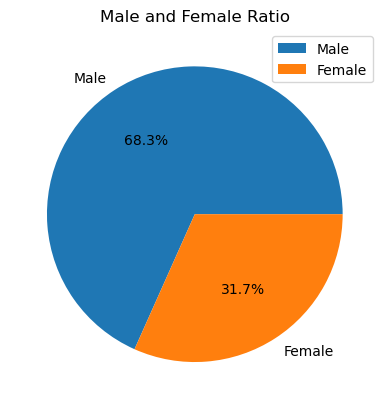

In [6]:
fig = plt.figure()
m,f = len(dataset[dataset['sex']=='Male']),len(dataset[dataset['sex']=='Female'])
plt.title(label='Male and Female Ratio')
plt.pie(x=[m,f],labels=['Male','Female'],autopct='%.1f%%')
plt.legend(labels=['Male','Female'])
plt.show()

In [7]:
dataset['sex'] = np.where(dataset['sex']=='Male',1,0)

## Age distribution of the patients

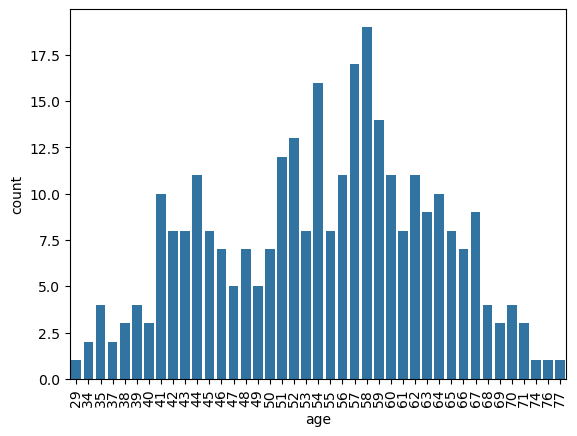

In [8]:
fig = plt.figure(dpi=100)
age_dist = dataset.groupby('age').size().reset_index(name='count')
sns.barplot(data=age_dist, x='age', y='count')
plt.xticks(rotation=90)
plt.show()

## Average Maximum heart-rate Achieved based on age

In [9]:
avg_max_heart = dataset.groupby('age')['thalach'].mean().astype(int).reset_index(name='avg_max_heart')

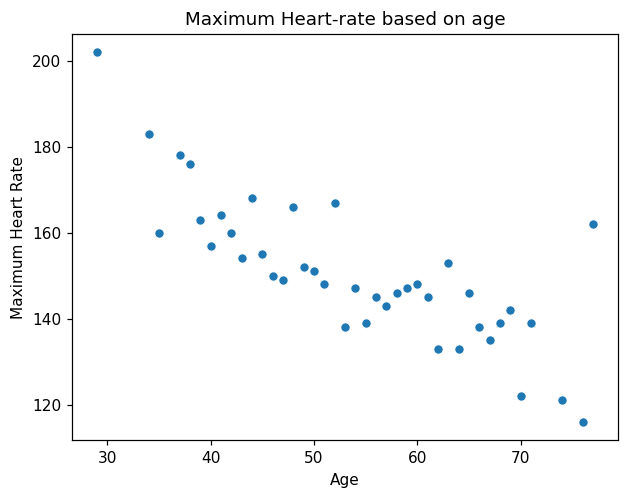

In [10]:
fig  = plt.figure(dpi=110)
sns.scatterplot(data=avg_max_heart,x='age',y='avg_max_heart')
plt.title(label='Maximum Heart-rate based on age')
plt.ylabel(ylabel='Maximum Heart Rate')
plt.xlabel(xlabel='Age')
plt.show()

# Data Preperation

In [11]:
X,y = dataset.drop('target',axis=1), dataset['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Finding the best Model

In [24]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500, step=100)
    max_features = trial.suggest_categorical("max_features", ["log2", "sqrt"])
    max_depth = trial.suggest_int("max_depth", 10, 110, step=20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4, step=1)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return cv_score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
random_forest_classifier_best_params = study.best_params
random_forest_classifier_best_value = study.best_value


[I 2024-08-13 13:13:45,331] A new study created in memory with name: no-name-1b280916-4142-4454-a626-b6c233645036
[I 2024-08-13 13:13:45,959] Trial 0 finished with value: 0.8062074829931973 and parameters: {'n_estimators': 400, 'max_features': 'log2', 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8062074829931973.
[I 2024-08-13 13:13:46,492] Trial 1 finished with value: 0.8062074829931973 and parameters: {'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8062074829931973.
[I 2024-08-13 13:13:46,912] Trial 2 finished with value: 0.8143707482993197 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8143707482993197.
[I 2024-08-13 13:13:47,035] Trial 3 finished with value: 0.8019557823129251 and parameters: {'n_estimators': 200, 'max_features': '

In [17]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1,log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        random_state=42,
        eval_metric='logloss'
    )

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return cv_score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
xgbc_classifier_best_params = study.best_params
xgbc_classifier_best_value = study.best_value

[I 2024-08-13 13:05:03,565] A new study created in memory with name: no-name-f3282951-59dc-460d-ae91-c244b376a0bc
[I 2024-08-13 13:05:03,601] Trial 0 finished with value: 0.5662414965986394 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0018536023699154728, 'subsample': 0.5113720501960797, 'colsample_bytree': 0.8865950227126864, 'gamma': 0.6671308414393512, 'min_child_weight': 6}. Best is trial 0 with value: 0.5662414965986394.
[I 2024-08-13 13:05:03,656] Trial 1 finished with value: 0.8267857142857142 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.023785643934267985, 'subsample': 0.9561774231303093, 'colsample_bytree': 0.8260946769040609, 'gamma': 4.91258186480748, 'min_child_weight': 6}. Best is trial 1 with value: 0.8267857142857142.
[I 2024-08-13 13:05:03,683] Trial 2 finished with value: 0.8225340136054422 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1831064147302898, 'subsample': 0.9851056705783687,

In [19]:
def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e3,log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3
    
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"]) if kernel != "linear" else "scale"

    model = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        random_state=42
    )

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return cv_score.mean()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
SVC_classifier_best_params = study.best_params
SVC_classifier_best_value = study.best_value

[I 2024-08-13 13:07:27,523] A new study created in memory with name: no-name-f5a69aec-cc65-49e0-ac44-d3d926a539bd
[I 2024-08-13 13:07:27,580] Trial 0 finished with value: 0.8060374149659865 and parameters: {'C': 1.701713666903095, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8060374149659865.
[I 2024-08-13 13:07:27,619] Trial 1 finished with value: 0.5579081632653061 and parameters: {'C': 0.03613879991647587, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.8060374149659865.
[I 2024-08-13 13:07:27,634] Trial 2 finished with value: 0.8306122448979592 and parameters: {'C': 0.19342459164726297, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.8306122448979592.
[I 2024-08-13 13:07:27,648] Trial 3 finished with value: 0.7769557823129252 and parameters: {'C': 0.002177515536330261, 'kernel': 'linear'}. Best is trial 2 with value: 0.8306122448979592.
[I 2024-08-13 13:07:27,662] Trial 4 finished with value: 0.7521258503401361 and parameters: 

## Plotting the difference between algorithms

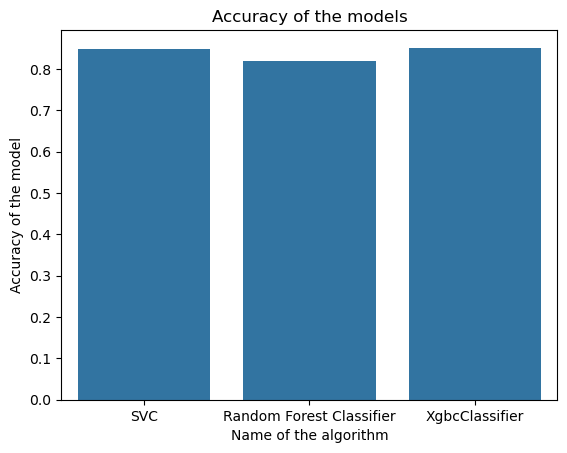

In [27]:
score = [SVC_classifier_best_value,random_forest_classifier_best_value,xgbc_classifier_best_value]
labels = ['SVC','Random Forest Classifier','XgbcClassifier']
fig = plt.figure()
sns.barplot(x=labels,y=score)
plt.ylabel(ylabel='Accuracy of the model')
plt.xlabel(xlabel='Name of the algorithm')
plt.title(label='Accuracy of the models')
plt.show()

# Making the final Pipeline

In [28]:
model = Pipeline(steps=[
    ('impute',SimpleImputer()),
    ('Scale',StandardScaler()),
    ('XGBC',XGBClassifier(**xgbc_classifier_best_params))
])

In [29]:
X,y = dataset.drop('target',axis=1), dataset['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [30]:
model.fit(X_train,y_train)

Pipeline(steps=[('impute', SimpleImputer()), ('Scale', StandardScaler()),
                ('XGBC',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7172212320283633, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=2.7499209716220374,
                               grow_pol...None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.20066189875113194, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [31]:
y_pred = model.predict(X_test)

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.79      0.90      0.84        30

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [35]:
final_accuracy_score = accuracy_score(y_test,y_pred)
final_accuracy_score

0.8360655737704918

# Saving the model

In [41]:
with open('Heart_disease_prediction.pkl', 'wb') as file:
    pickle.dump(model,file)